In [1]:
%env CUDA_VISIBLE_DEVICES=4
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=4


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import utils.plot_functions as pf
import numpy as np
from cae_model import cae
import time

In [3]:
params = {}
#shitty hard coding
params["n_mem"] = 32768  #32768 #49152 for color, 32768 for grayscale

#general params
params["run_name"] = "7680_med_compress_pcm"
params["file_location"] = "/media/tbell/datasets/natural_images.txt"
params["gpu_ids"] = ["0"]
params["output_location"] = os.path.expanduser("~")+"/CAE_Project/CAEs/model_outputs/"+params["run_name"]
params["num_threads"] = 6
params["num_epochs"] = 40
params["epoch_size"] = 112682
params["eval_interval"] = 100
params["seed"] = 1234567890

#checkpoint params
params["run_from_check"] = False
params["check_load_run_name"] = "train"
params["check_load_path"] = "/home/dpaiton/CAE_Project/CAEs/model_outputs/"+params["check_load_run_name"]+"/checkpoints/chkpt_-22800"

#image params
params["shuffle_inputs"] = True
params["batch_size"] = 100
params["img_shape_y"] = 256
params["num_colors"] = 1
params["downsample_images"] = True
params["downsample_method"] = "resize" # can be "crop" or "resize"

#learning rates
params["init_learning_rate"] = 5.0e-4
params["decay_steps"] = 10000#epoch_size*0.5*num_epochs #0.5*epoch_size
params["staircase"] = True
params["decay_rate"] = 0.9

#layer params
params["memristorify"] = False
params["god_damn_network"] = True
params["relu"] = False

#layer dimensions
params["input_channels"] = [params["num_colors"], 128, 128]
params["output_channels"] = [128, 128, 128]
params["patch_size_y"] = [9, 5, 5]
params["strides"] = [4, 2, 2]

#memristor params
params["GAMMA"] = 1.0  # slope of the out of bounds cost
params["mem_v_min"] = -1.0
params["mem_v_max"] = 1.0
params["gauss_chan"] = False

cae_model = cae(params)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = False
config.log_device_placement = False # for debugging - log devices used by each variable

with tf.Session(config=config, graph=cae_model.graph) as sess:
  sess.run(cae_model.init_op)
  if cae_model.params["run_from_check"] == True:
    cae_model.full_saver.restore(sess, cae_model.params["check_load_path"])
  # Coordinator manages threads, checks for stopping requests
  coord = tf.train.Coordinator()
  # queue_runners are created by helper functions tf.train.string_input_producer() and tf.train.batch_join()
  enqueue_threads = tf.train.start_queue_runners(sess, coord=coord, start=True)

  #_, step, u_list = sess.run([cae_model.train_op, cae_model.global_step, cae_model.u_list])
  #u_vals = u_list[int(params["num_layers"]/2)]
  t0 = time.time()
  latent_ent_list, u_list = sess.run([cae_model.latent_entropies, cae_model.u_list])
  t1 = time.time()
  t_tot = t1-t0
  print("total_time: ",t_tot)
  
  coord.request_stop()
  coord.join(enqueue_threads)

total_time:  9.764407396316528


In [4]:
def plot_hists(latent_vals, u_vals, num_plots):
    fig, ax = plt.subplots(num_plots, figsize=(20, 5*num_plots))
    if num_plots == 1:
        ax = [ax]
    for plot in range(num_plots):
        entropy, hist, bin_edges, unit_entropies, entropies_m0, entropies = latent_vals[plot]
        ax[plot].scatter(bin_edges, hist)
        for index in np.arange(len(hist[:-1])):
          x_points = [bin_edges[index], bin_edges[index+1]]
          y_points = [hist[index], hist[index+1]]
          ax[plot].plot(x_points, y_points, linewidth=2, color="k")
        ax[plot].set_title("Entropy="+str(round(entropy,2)), fontsize=18)
        ylim = ax[plot].get_ylim()
        ax[plot].set_ylim((0, ylim[1]))
    plt.show()

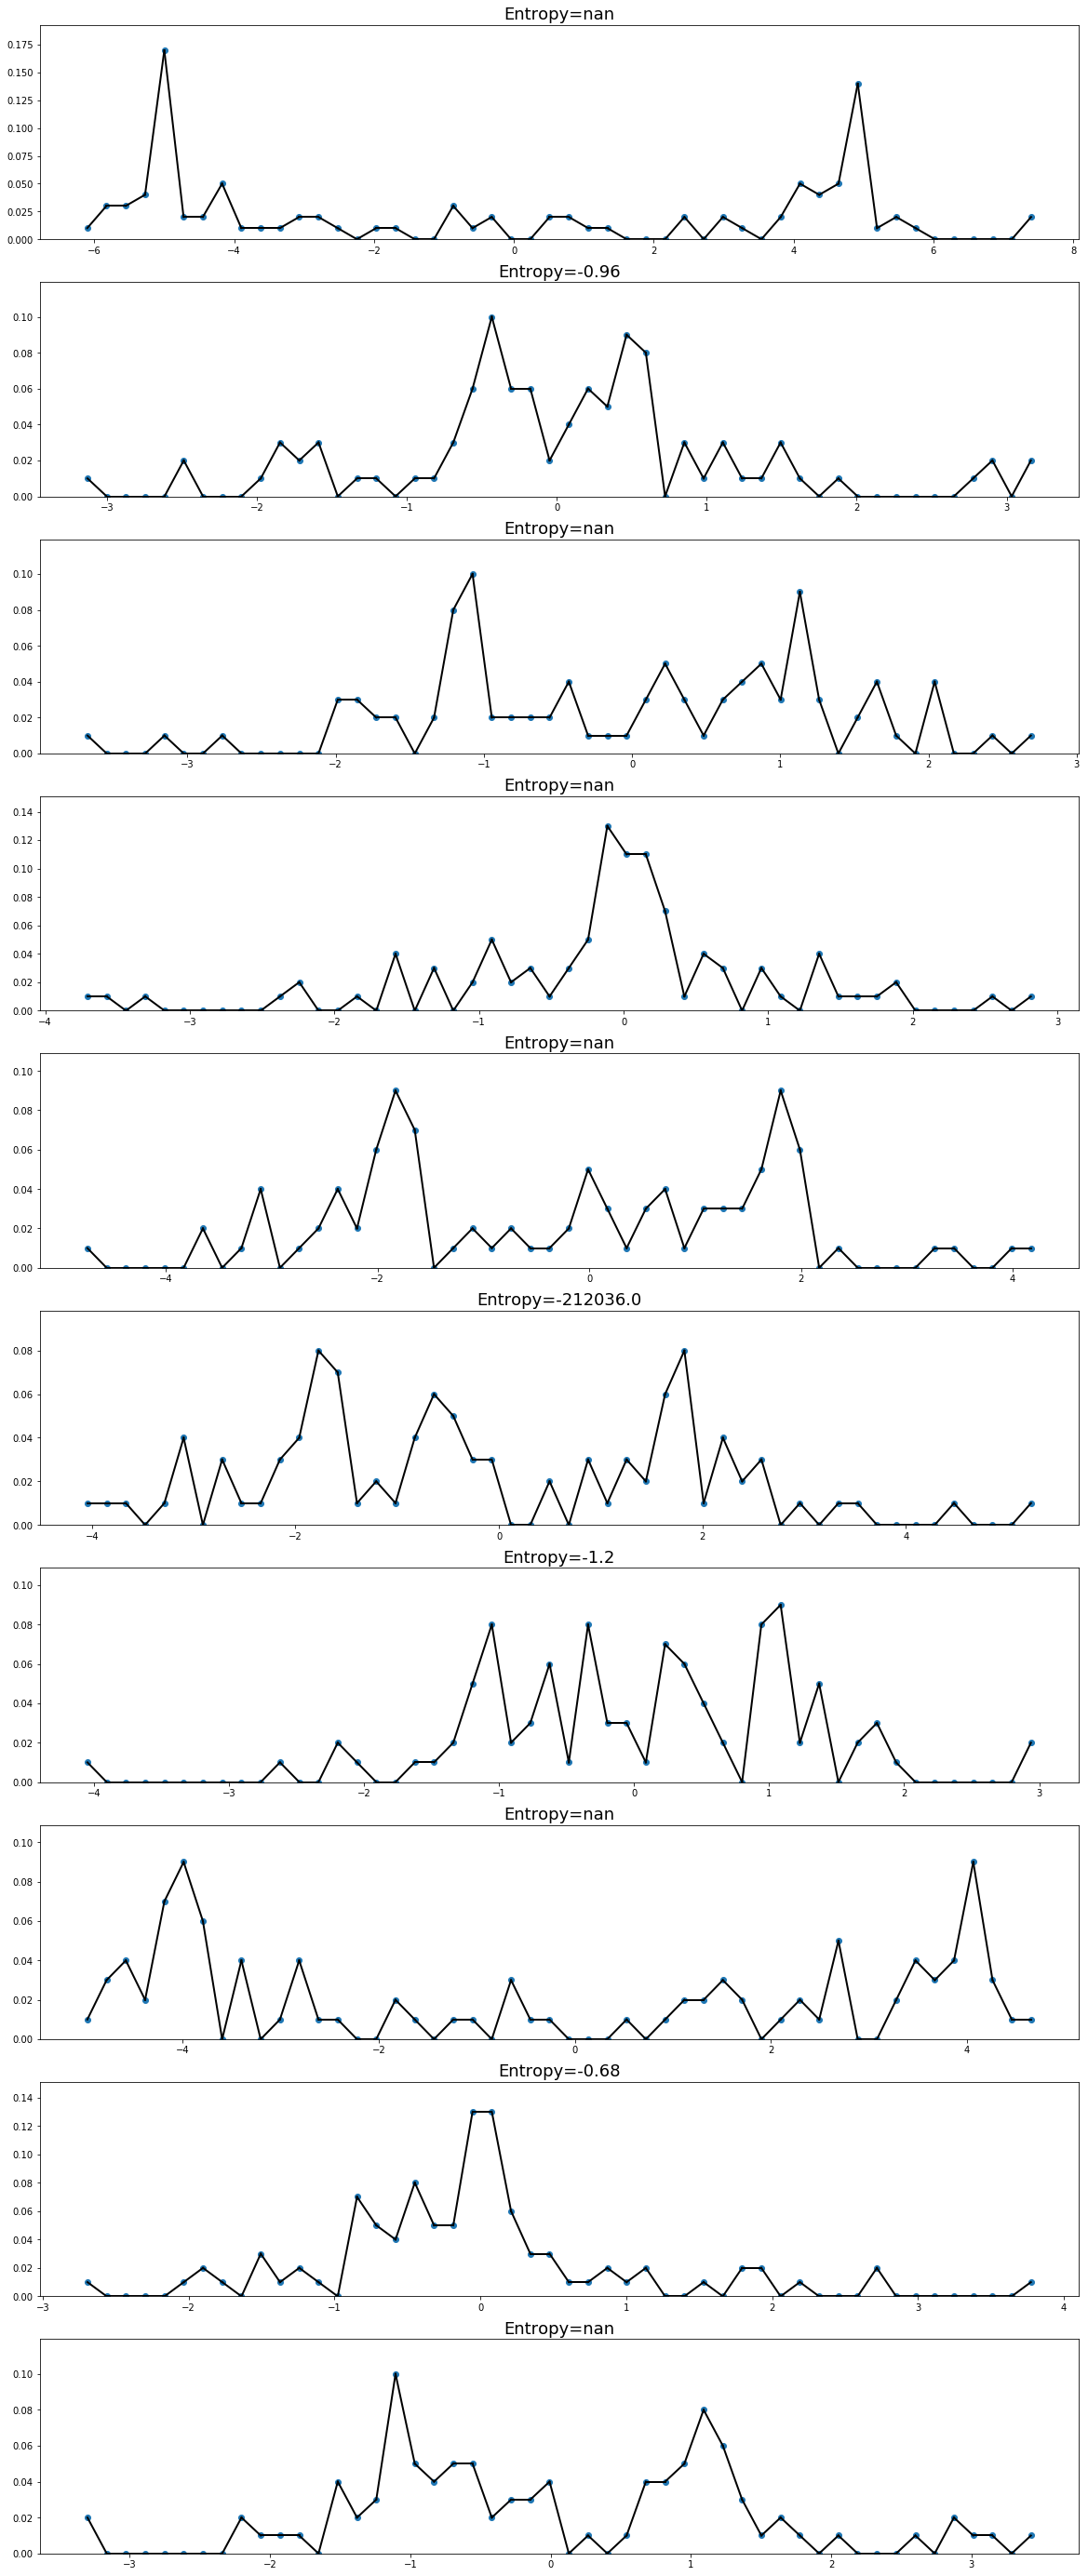

In [5]:
num_plots = 10
rand_val_index = np.random.choice(len(latent_ent_list), num_plots, replace=False)
latent_vals = [latent_ent_list[idx] for idx in rand_val_index]
u_vals = tf.reshape(u_list[int(params["num_layers"]/2)], shape=(params["batch_size"], params["n_mem"]), name="u_vals")
plot_hists(latent_vals, u_vals=u_vals, num_plots=num_plots)